In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization import (
rg_step, renormalized_field, dH_dH, G_r_prime, G_prime, phi_from_G)
from utils import build_J

In [9]:
def find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=100, tol=1e-5,
            growth_threshold=1e3, decay_threshold=1e-3):

    if not (0 < a <= 2):
        raise ValueError("a must be in (0,2)")

    def grows(J0):
        J = build_J(J0, a, D=max_distance)
        J1_initial = abs(J[1])

        for _ in range(10):

            # early decision:
            if abs(J[1]) > growth_threshold:
                return True   # flows to ordered phase
            if abs(J[1]) < decay_threshold:
                return False  # flows to disordered phase

            # apply full RG step
            J = rg_step(J, a)

        # fallback: check increasing or decreasing tendency
        return abs(J[1]) > J1_initial

    # Bisection on J0: growth → ordered, decay → disordered
    while (Jhigh - Jlow) > tol:
        Jmid = 0.5 * (Jlow + Jhigh)
        if grows(Jmid):
            Jhigh = Jmid
        else:
            Jlow = Jmid

    return 0.5 * (Jlow + Jhigh)


def magnetization(J0, a, Jc, D, n_steps=10, eps=1e-6):
    # Disordered side
    if J0 <= Jc:
        return 0.0

    # Ordered sink magnetization (by convention)
    M_sink = 1.0

    # Spatial dimension & rescaling factor
    b = 3.0
    d = 1.0

    # Initial couplings
    J = build_J(J0, a, D)

    prod_R = 1.0
    k = 0

    for step in range(n_steps):
        dH = dH_dH(J, eps=eps)
        if not np.isfinite(dH) or dH <= 0.0:
            break

        prod_R *= dH
        k += 1

        J = rg_step(J, a)

    if k == 0:
        return 0.0

    scale = (b ** (-d)) ** k
    M0 = scale * prod_R * M_sink
    return float(M0)


def generate_rg_flow(J0, a, D, n_steps):

    J = build_J(J0, a, D)
    flow = [J.copy()]
    
    for _ in range(n_steps):
        J = rg_step(J, a)
        flow.append(J.copy())
    
    return flow


def plot_rg_flow(flow, distances_to_plot=None):

    n_steps_plus_1 = len(flow)
    D = len(flow[0]) - 1
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = [1, 2, 3, 4, 5]

    plt.figure(figsize=(7, 5))
    for r in distances_to_plot:
        if 1 <= r <= D:
            vals = np.array([J[r] for J in flow])
            plt.plot(steps, vals, marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling J_r")
    plt.title("Fixed-length RG flow of couplings")
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_Jc_over_a(a_values, max_distance):
    Jc_values = []
    for a in a_values:
        Jc = find_Jc(a, max_distance=max_distance)
        Jc_values.append(Jc)
    return np.array(Jc_values)


def plot_Tc_vs_a(a_values, Jc_values):
    Tc_values = 1.0 / Jc_values
    plt.figure(figsize=(7, 5))
    plt.plot(a_values, Tc_values, "-o", markersize=5)
    plt.xlabel("Interaction exponent a")
    plt.ylabel("Critical temperature Tc = 1/Jc")
    plt.title("Critical temperature Tc vs a (fixed-length RG)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

# RG flow

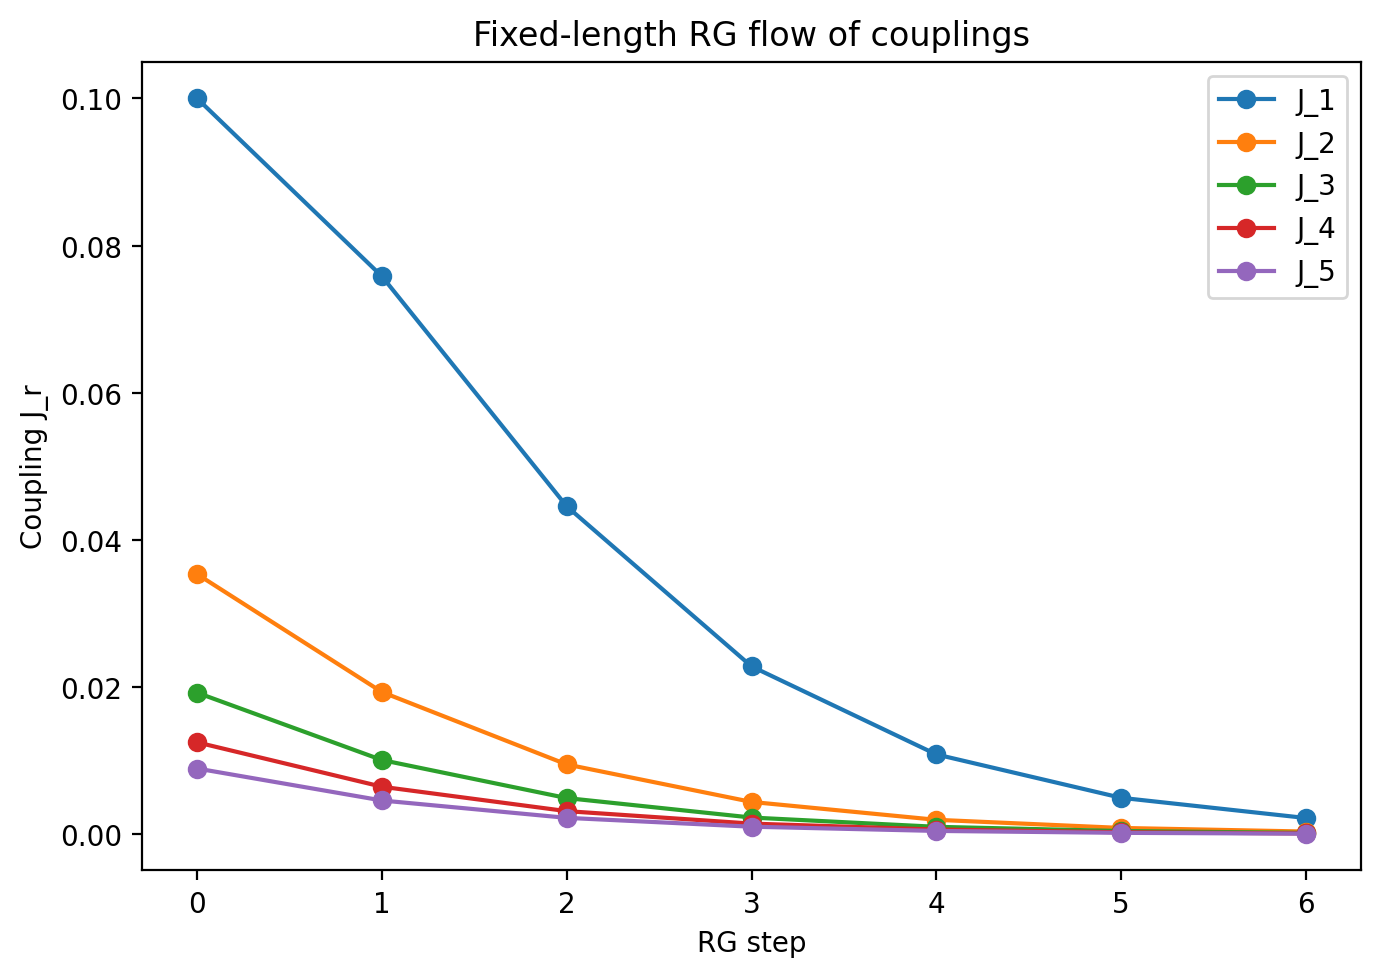

In [10]:
a = 1.5
D = 100
n_steps = 6

J0 = .1

flow = generate_rg_flow(J0, a, D, n_steps)
plot_rg_flow(flow, distances_to_plot=[1, 2, 3, 4, 5])

# Critical temperature line

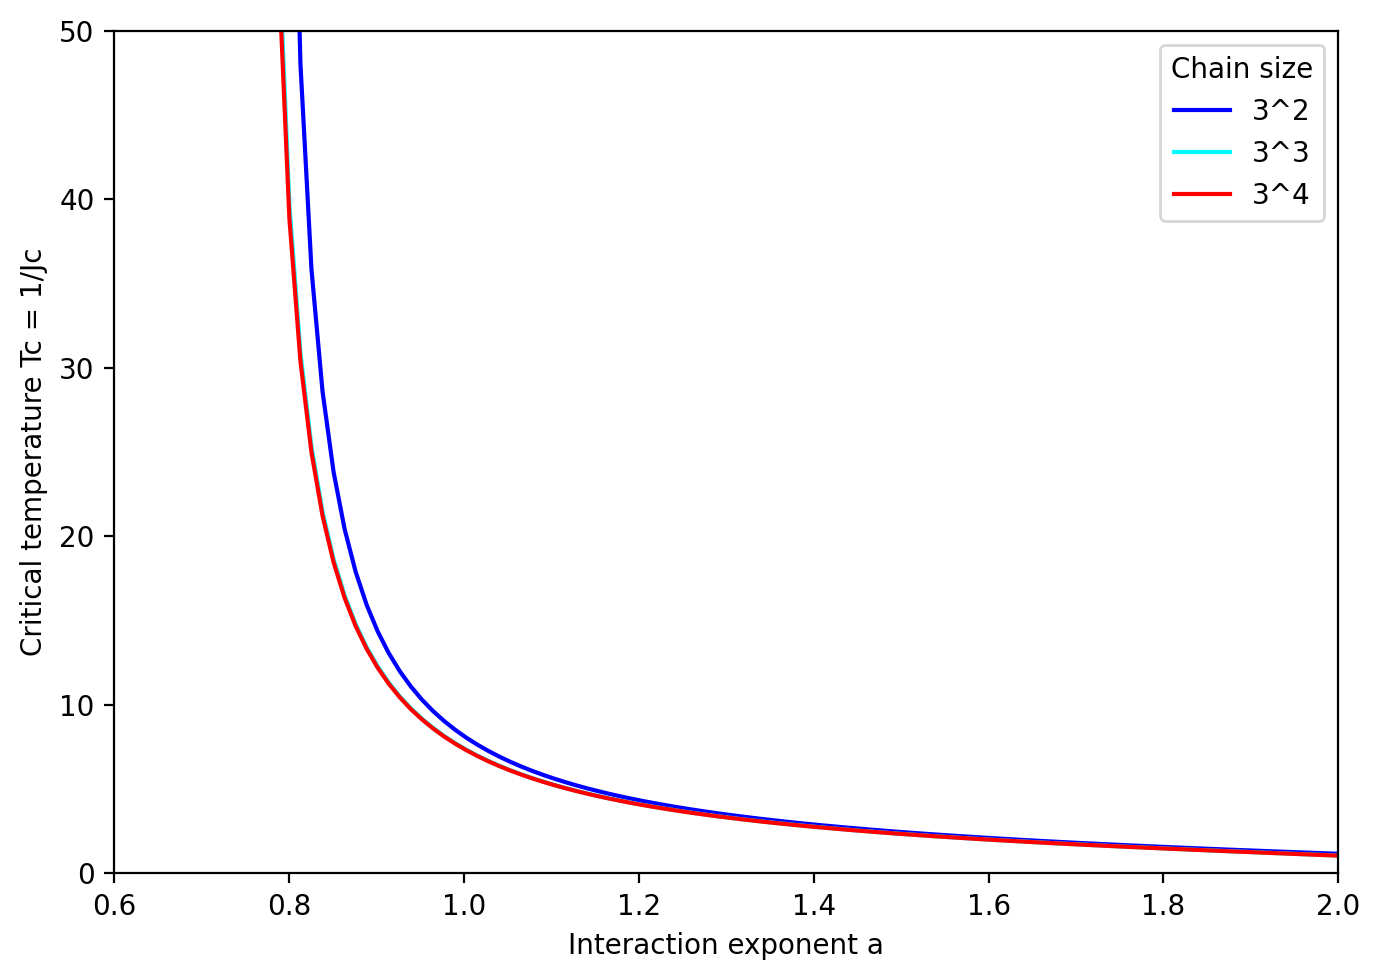

In [15]:
# Range of exponents
a_values = np.linspace(0.75, 2.0, 100)

plt.figure(figsize=(7, 5))
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**2), c='b', label='3^2')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**3), c='cyan', label='3^3')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**4), c='r', label='3^4')
plt.xlabel("Interaction exponent a")
plt.ylabel("Critical temperature Tc = 1/Jc")
plt.legend(title='Chain size')
plt.xlim(0.6, 2)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

# Magnetization

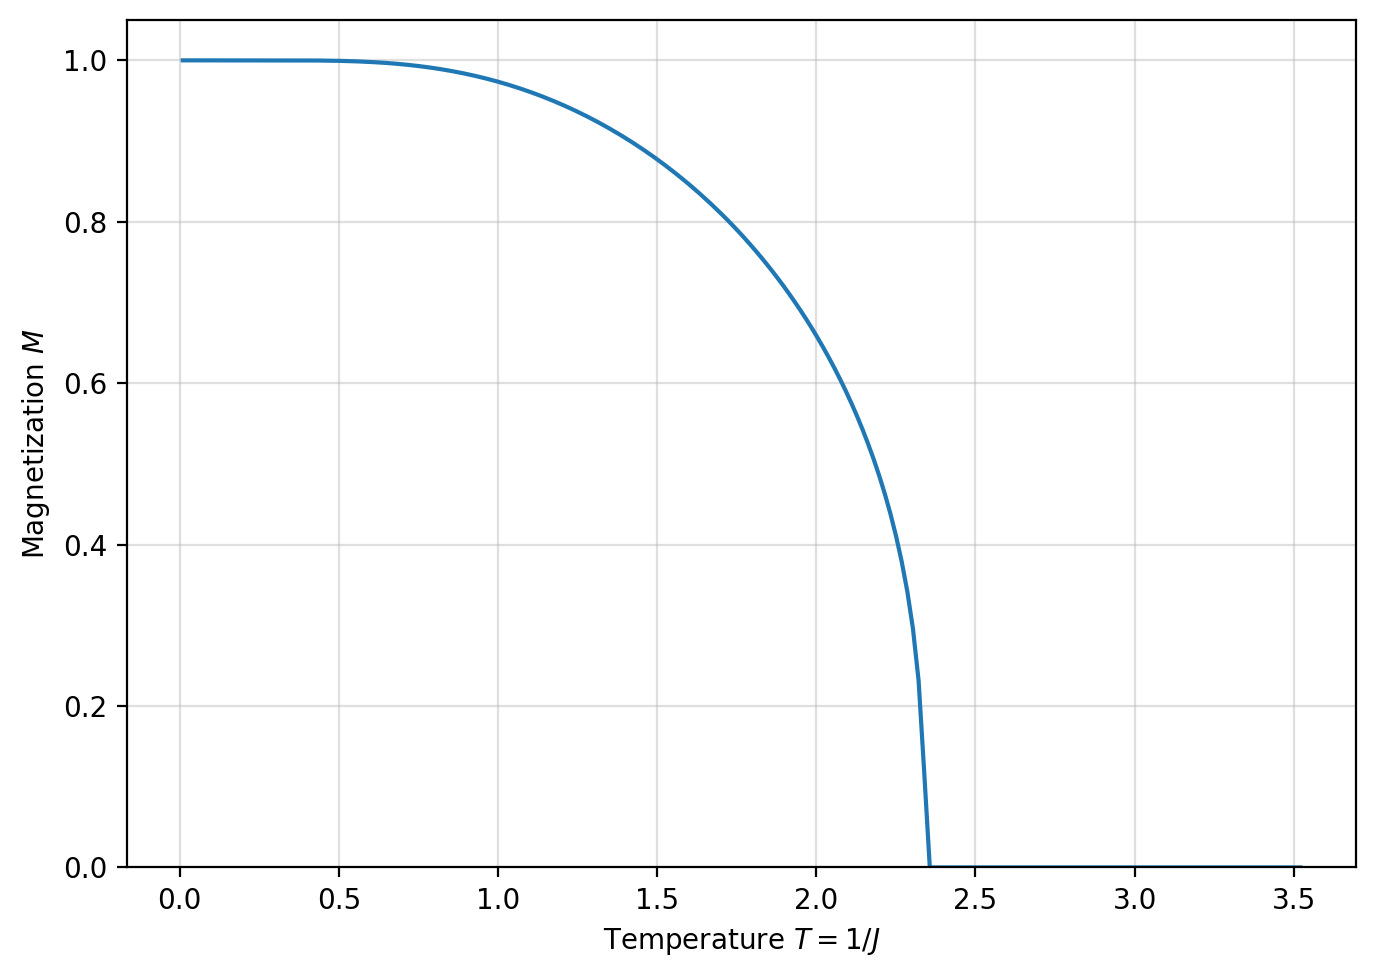

In [24]:
a = 1.5

if a < 0.8:
    Jc = 1e-10
    T_vals = np.linspace(0.01, 100, 200)
    J_vals = 1.0 / T_vals
else:
    Jc = find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=100, tol=1e-6, growth_threshold=1e3, decay_threshold=1e-3)
    T_vals = np.linspace(0.01, 1.5 / Jc, 200)
    J_vals = 1.0 / T_vals

M_vals = [
    magnetization(J0, a, Jc, D=1000, n_steps=12)
    for J0 in J_vals]

plt.figure(figsize=(7, 5))
plt.plot(T_vals, M_vals, '-', markersize=3)
plt.xlabel(r"Temperature $T = 1/J$")
plt.ylabel(r"Magnetization $M$")
plt.ylim(0, None)
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

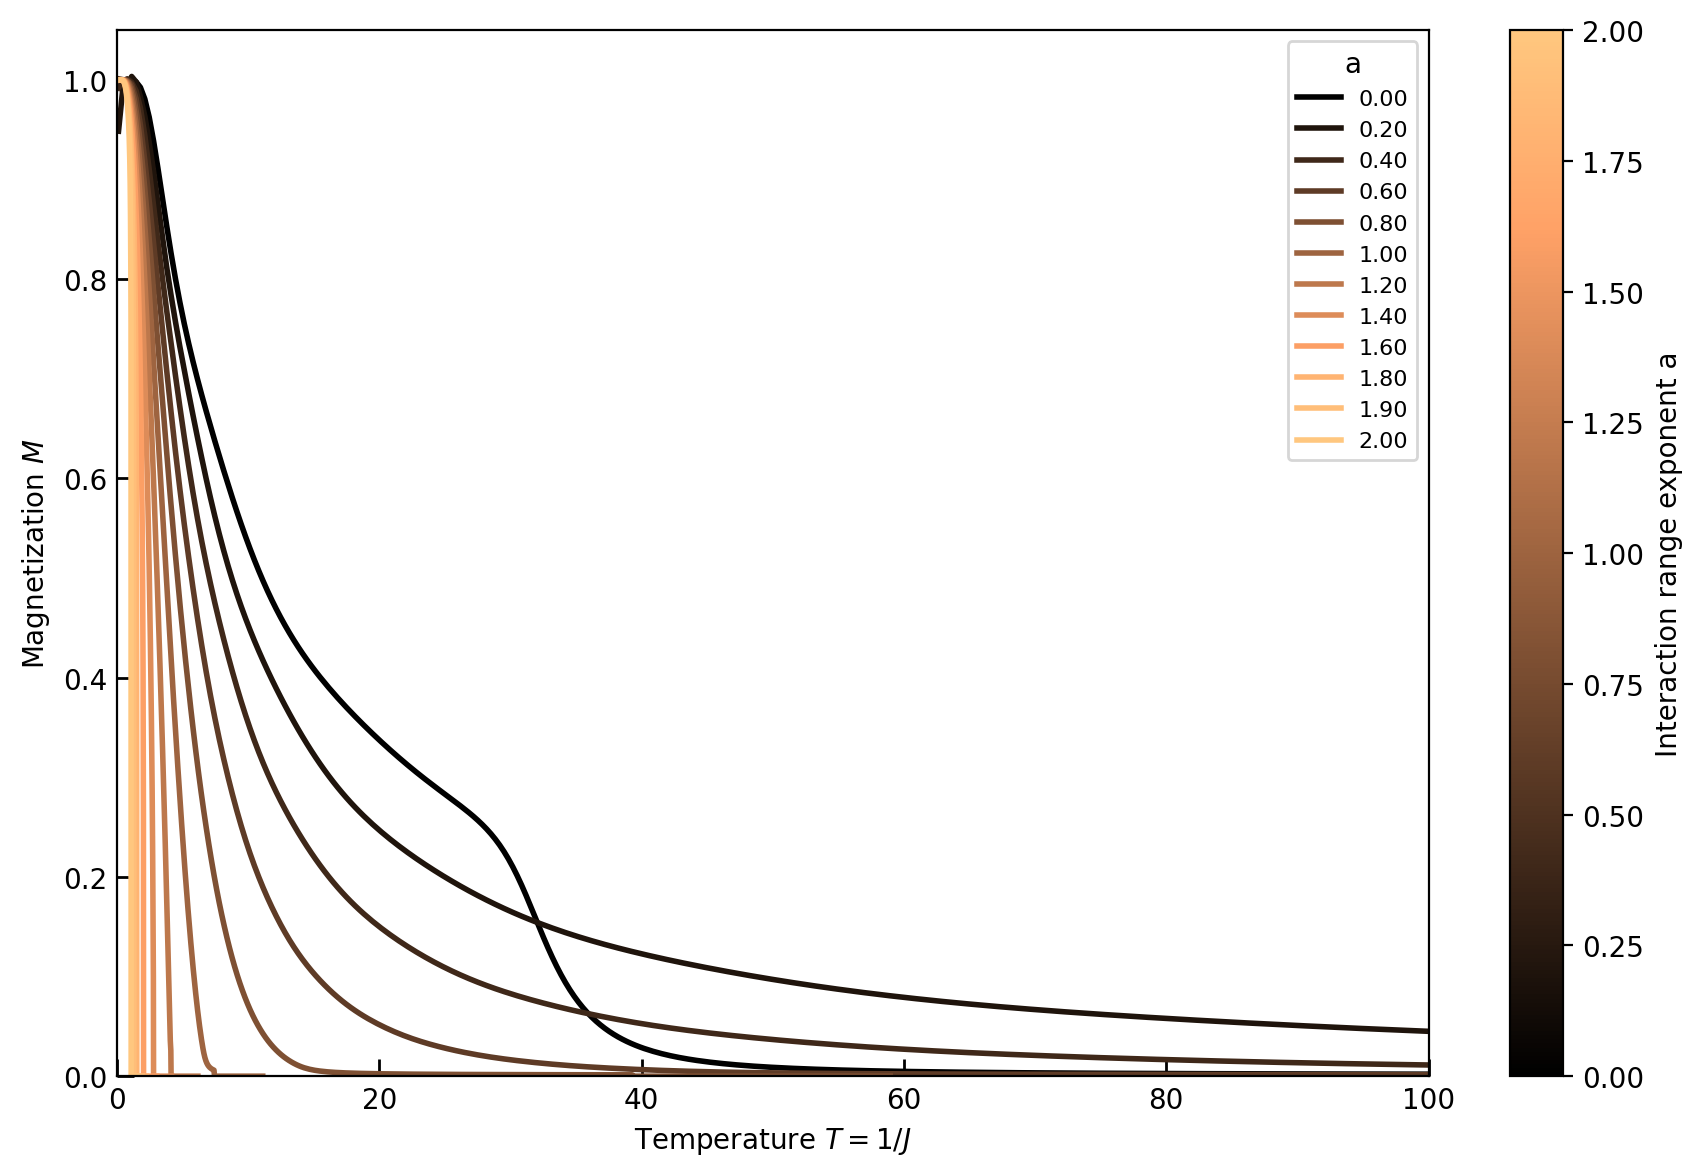

In [25]:
from matplotlib import cm


D = 100
n_steps_Jc = 10
n_steps_M  = 10
eps = 1e-6

a_values = np.array([0.0 , 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.9, 2.0])
data_by_a = []

for a in a_values:
    if a < 0.8:
        Jc = 1e-12
        T_arr = np.linspace(0.1, 100, 300)
        J_arr = 1.0 / T_arr

    else:
        Jc = find_Jc(a,
                     Jlow=1e-2,
                     Jhigh=1e2,
                     max_distance=100,
                     tol=1e-6,
                     growth_threshold=1e3,
                     decay_threshold=1e-3)

        T_arr = np.linspace(0.10, 1.5 / Jc, 300)
        J_arr = 1.0 / T_arr

    # compute magnetization curve
    M_arr = np.array([
        magnetization(J0, a, Jc,
                      D=D,
                      n_steps=n_steps_M,
                      eps=eps)
        for J0 in J_arr
    ])

    data_by_a.append((T_arr, M_arr))


# PLOT
fig, ax = plt.subplots(figsize=(9, 6))

cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for a, (T_arr, M_arr) in zip(a_values, data_by_a):
    ax.plot(T_arr, M_arr,
            color=cmap(norm(a)),
            linewidth=2,
            label=f"{a:.2f}")

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Interaction range exponent a')

ax.set_xlabel(r"Temperature $T = 1/J$")
ax.set_ylabel(r"Magnetization $M$")
ax.set_xlim(0, 100)
ax.set_ylim(0, 1.05)
ax.legend(title="a", fontsize=8, framealpha=0.8)
ax.tick_params(axis='both', direction='in', width=1, length=6)
plt.tight_layout()
plt.show()

# Energy densities

In [3]:
def u_r(T, a, r_list, max_steps=8, D_fixed=100, dJ_rel=1e-3):
    J0 = 1.0 / T
    r_list = np.array(r_list, dtype=np.int64)

    J_base = build_J(J0, a, D_fixed)
    
    results = {}
    for r in r_list:
        J_r0 = J_base[r]
        dJ = dJ_rel * abs(J_r0) if J_r0 != 0 else dJ_rel

        Jp = J_base.copy()
        Jp[r] = J_r0 + dJ

        phi_p = phi_from_G(Jp, max_steps, a)
        phi = phi_from_G(J_base, max_steps, a)
        dphi_dJr = abs(phi_p - phi) / dJ
        results[r] = dphi_dJr / D_fixed
    return results

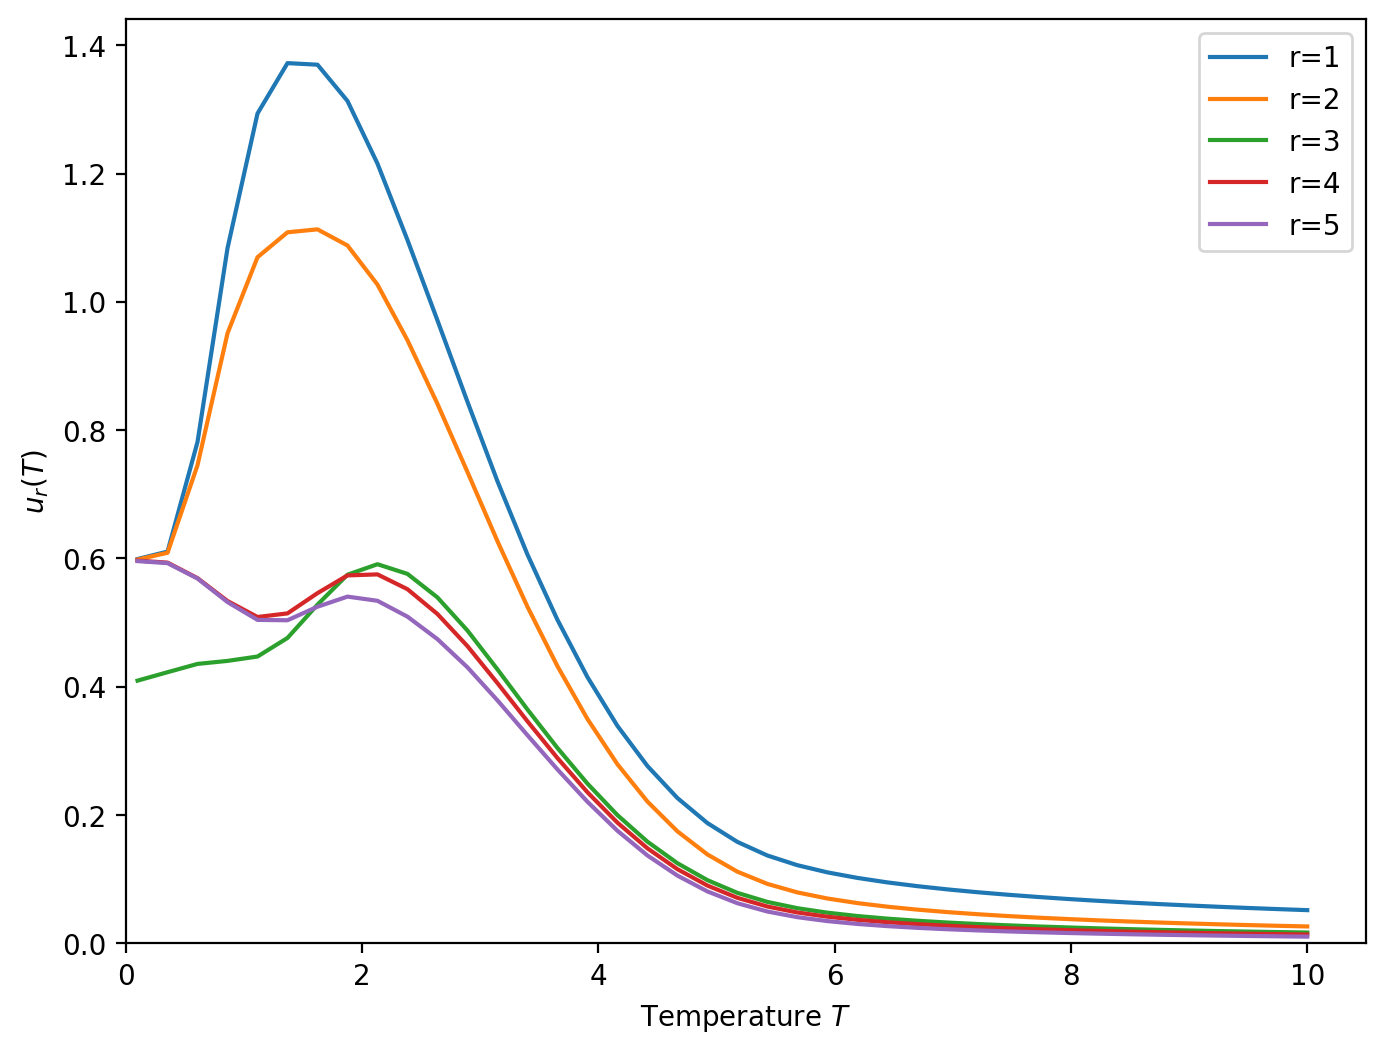

In [6]:
a = 1.
r_values = [1, 2, 3, 4, 5]
T_values = np.linspace(0.1, 10, 40)
u_results = {r: [] for r in r_values}

for T in T_values:
    ur_dict = u_r(T, a, r_values, max_steps=6, D_fixed=30, dJ_rel=1e-3)
    for r in r_values:
        u_results[r].append(ur_dict[r])

plt.figure(figsize=(8, 6))
for r in r_values:
    plt.plot(T_values, u_results[r], label=f"r={r}")
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("$u_r(T)$")
plt.legend()
plt.show()

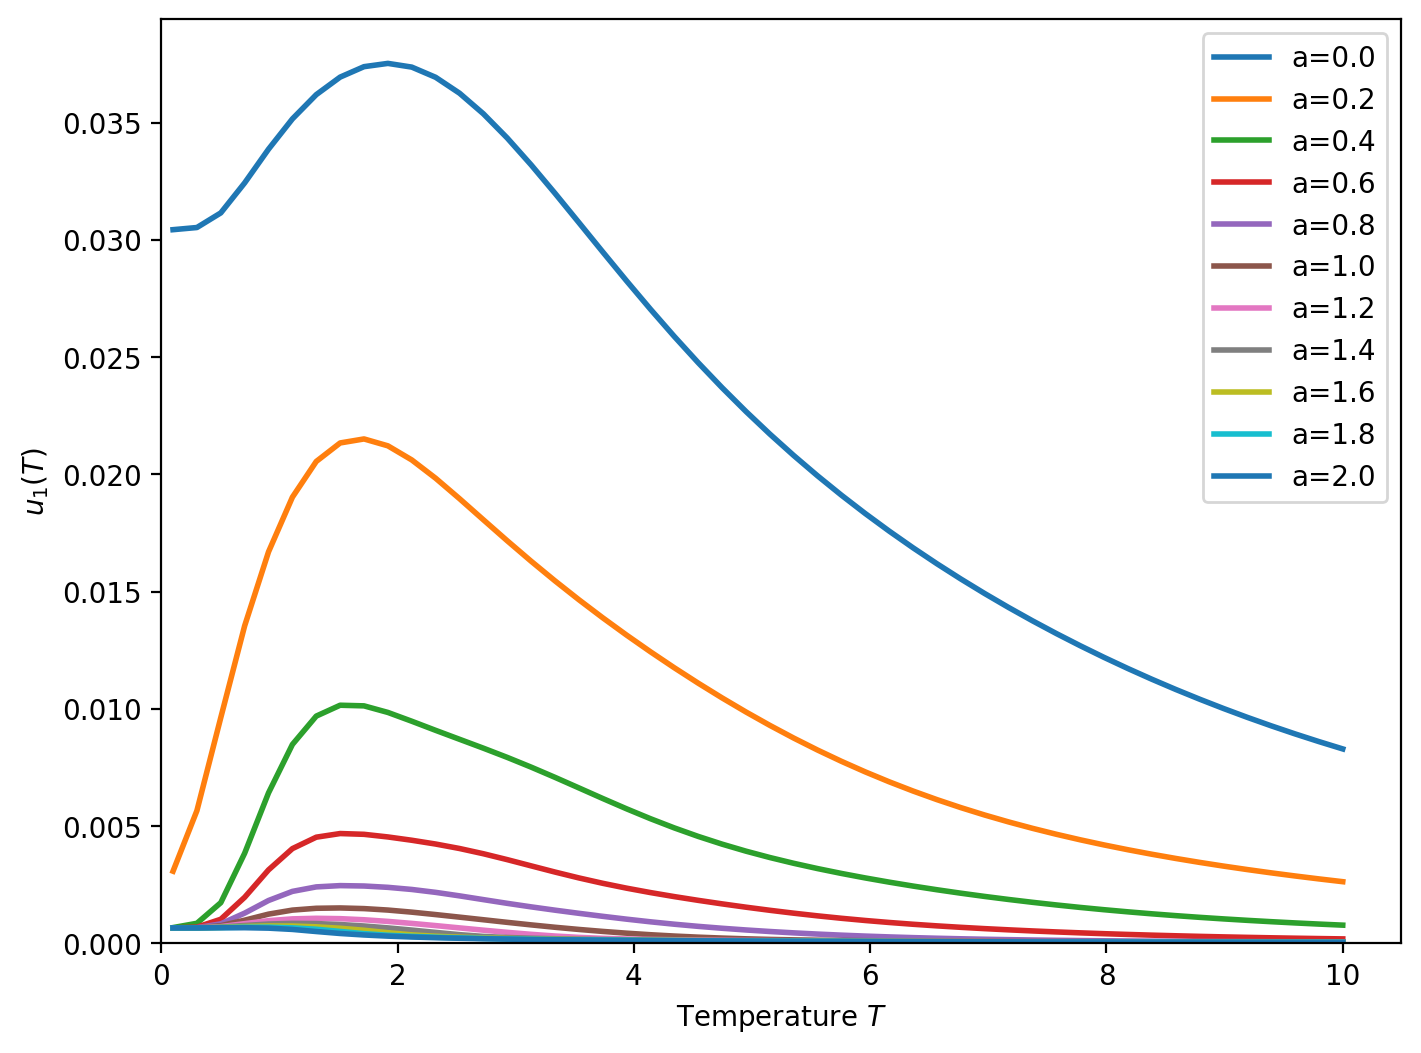

In [103]:
r_values = [1]
a_values = np.linspace(0, 2, 11)
T_values = np.linspace(0.1, 10, 50)

u_results = {a: {r: [] for r in r_values} for a in a_values}

for a in a_values:
    for T in T_values:
        ur_dict = u_r(T, a, r_values, max_steps=6, D_fixed=3**6, dJ_rel=1e-3)
        for r in r_values:
            u_results[a][r].append(ur_dict[r])

for r in r_values:
    plt.figure(figsize=(8, 6))
    for a in a_values:
        plt.plot(T_values, u_results[a][r], label=f"a={round(a,3)}", lw=2)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel("Temperature $T$")
    plt.ylabel(f"$u_{r}(T)$")
    plt.legend()
    plt.show()

# Fixed point

In [11]:

# --- Tail closure: build a fixed-size coupling vector from head x[1..n] ---
def build_full_from_head(x_head, a, D, anchor_at_n=True):
    """
    x_head: array of length n+1 with x_head[0] ignored (kept 0), x_head[1..n] are variables.
    Returns J_full of length D+1.
    """
    n = len(x_head) - 1
    J = np.zeros(D + 1, dtype=np.float64)
    J[1:n+1] = x_head[1:n+1]

    if anchor_at_n:
        anchor = J[n]
        for r in range(n + 1, D + 1):
            J[r] = anchor * (n / r) ** a
    else:
        # alternative: zero tail (hard cutoff) — not used here
        pass

    return J


def rg_projected_map(x_head, a, D, n):
    """
    Defines the finite-dimensional RG map R_n(x) = first n components of rg_step(J_full(x), a).
    """
    J_full = build_full_from_head(x_head, a=a, D=D, anchor_at_n=True)
    Jp_full = rg_step(J_full, a=a)  # your njit RG step (fixed-size due to tail)
    xp = np.zeros(n + 1, dtype=np.float64)
    xp[1:n+1] = Jp_full[1:n+1]
    return xp, Jp_full


def newton_fixed_point_rg(
    a,
    D=200,
    n=50,
    x0_head=None,
    max_iter=25,
    tol_F=1e-10,
    tol_dx=1e-10,
    eps0=1e-7,
    damping_init=1.0,
    max_backtrack=12,
    verbose=True,
):
    """
    Newton–Raphson solve for fixed point of the truncated head couplings (size n),
    with deterministic power-law tail closure and fixed total cutoff D.

    Solves: F(x) = R_n(x) - x = 0  in R^n
    Returns:
      x_star_head (n+1), J_star_full (D+1), info dict
    """

    # Consistency: n must lie in the exact head region of rg_step
    r_max = (D - 2) // 3
    if n > r_max:
        raise ValueError(
            f"Choose n <= r_max. Here D={D} gives r_max={r_max}, but n={n}."
        )

    # Initialize x
    if x0_head is None:
        raise ValueError("Provide x0_head (head vector length n+1) as initial guess.")
    x = x0_head.astype(np.float64).copy()
    x[0] = 0.0

    def residual_and_map(x_head):
        xp_head, Jp_full = rg_projected_map(x_head, a=a, D=D, n=n)
        F = xp_head[1:n+1] - x_head[1:n+1]
        return F, xp_head, Jp_full

    # Initial residual
    F, xp_head, Jp_full = residual_and_map(x)
    F_norm = np.linalg.norm(F)
    if verbose:
        print(f"[Newton] init: ||F|| = {F_norm:.3e}  (D={D}, n={n}, r_max={r_max})")

    for it in range(1, max_iter + 1):
        # Check convergence
        if F_norm < tol_F:
            J_star_full = build_full_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {
                "converged": True,
                "iterations": it - 1,
                "F_norm": F_norm,
            }

        # Build Jacobian of F: J_F = d(R_n)/dx - I
        # We compute d(R_n)/dx via forward finite differences.
        JF = np.zeros((n, n), dtype=np.float64)

        # Baseline mapped head xp_head already computed above.
        base_xp = xp_head.copy()

        for j in range(1, n + 1):
            step = eps0 * max(1.0, abs(x[j]))
            x_pert = x.copy()
            x_pert[j] += step

            xp_pert, _ = rg_projected_map(x_pert, a=a, D=D, n=n)

            dR = (xp_pert[1:n+1] - base_xp[1:n+1]) / step
            JF[:, j - 1] = dR

        # Subtract identity for F = R - x
        JF -= np.eye(n, dtype=np.float64)

        # Solve JF * dx = -F
        rhs = -F
        try:
            dx = np.linalg.solve(JF, rhs)
        except np.linalg.LinAlgError:
            # fallback: least squares if singular/ill-conditioned
            dx, *_ = np.linalg.lstsq(JF, rhs, rcond=None)

        dx_norm = np.linalg.norm(dx)
        if verbose:
            print(f"[Newton] iter {it:02d}: ||F||={F_norm:.3e}, ||dx||={dx_norm:.3e}")

        # Damped update with backtracking line search on ||F||
        alpha = damping_init
        success = False
        x_trial = x.copy()

        for bt in range(max_backtrack + 1):
            x_trial[1:n+1] = x[1:n+1] + alpha * dx  # dx solves for head variables
            x_trial[0] = 0.0

            F_trial, xp_trial, _ = residual_and_map(x_trial)
            F_trial_norm = np.linalg.norm(F_trial)

            if np.isfinite(F_trial_norm) and F_trial_norm < F_norm:
                success = True
                x = x_trial.copy()
                F = F_trial
                xp_head = xp_trial
                F_norm = F_trial_norm
                break

            alpha *= 0.5

        if not success:
            # If no improvement, stop (Newton cannot progress reliably)
            J_star_full = build_full_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {
                "converged": False,
                "iterations": it,
                "F_norm": F_norm,
                "reason": "line_search_failed",
            }

        # Second convergence test: small step
        if dx_norm < tol_dx * (1.0 + np.linalg.norm(x[1:n+1])):
            J_star_full = build_full_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {
                "converged": True,
                "iterations": it,
                "F_norm": F_norm,
                "reason": "small_step",
            }

    J_star_full = build_full_from_head(x, a=a, D=D, anchor_at_n=True)
    return x, J_star_full, {
        "converged": False,
        "iterations": max_iter,
        "F_norm": F_norm,
        "reason": "max_iter",
    }

In [12]:

a = 1.0
Jc = find_Jc(a)
print("Critical Jc =", Jc)

# Choose D and n such that n <= (D-2)//3
D = 200
n = 50
r_max = (D - 2) // 3
print("r_max =", r_max)

# Initial head guess from power law at Jc
x0 = np.zeros(n + 1, dtype=np.float64)
for r in range(1, n + 1):
    x0[r] = Jc / (r ** a)

x_star_head, J_star_full, info = newton_fixed_point_rg(
    a=a, D=D, n=n, x0_head=x0, verbose=True)

print("Newton info:", info)
print("Fixed point couplings J =", x_star_head)

Critical Jc = 0.1351721367239952
r_max = 66
[Newton] init: ||F|| = 2.238e-02  (D=200, n=50, r_max=66)
[Newton] iter 01: ||F||=2.238e-02, ||dx||=3.816e-02
[Newton] iter 02: ||F||=2.317e-04, ||dx||=9.951e-04
[Newton] iter 03: ||F||=8.854e-07, ||dx||=2.616e-06
Newton info: {'converged': True, 'iterations': 3, 'F_norm': np.float64(1.162994327143203e-11)}
Fixed point couplings J = [0.         0.17414966 0.06731012 0.04375444 0.03254546 0.02593913
 0.0215727  0.01846886 0.01614781 0.01434605 0.01290659 0.01173
 0.01075023 0.00992166 0.00921177 0.00859675 0.00805876 0.00758419
 0.00716246 0.00678518 0.00644567 0.00613853 0.00585934 0.00560444
 0.00537081 0.00515587 0.00495748 0.0047738  0.00460324 0.00444446
 0.00429626 0.00415763 0.00402767 0.00390558 0.00379068 0.00368235
 0.00358004 0.00348326 0.00339158 0.0033046  0.00322197 0.00314337
 0.00306852 0.00299715 0.00292902 0.00286392 0.00280165 0.00274203
 0.0026849  0.0026301  0.00257749]


In [16]:
def compute_recursion_matrix_dR(x_head_star, a, D, n, eps0=1e-7):
    """
    Compute T_ij = d J'_i / d J_j for the finite-dimensional head map R_n(x),
    evaluated at x_head_star.

    Returns:
      T: (n x n) recursion matrix (dR/dx)
      xprime_head: R_n(x_star) as head vector (n+1)
    """
    # baseline map
    xprime_head, _ = rg_projected_map(x_head_star, a=a, D=D, n=n)
    base = xprime_head.copy()

    T = np.zeros((n, n), dtype=np.float64)

    for j in range(1, n + 1):
        step = eps0 * max(1.0, abs(x_head_star[j]))
        x_pert = x_head_star.copy()
        x_pert[j] += step

        xprime_pert, _ = rg_projected_map(x_pert, a=a, D=D, n=n)

        # column j-1
        T[:, j - 1] = (xprime_pert[1:n+1] - base[1:n+1]) / step

    return T, base


def thermal_exponent_yT(x_head_star, a, D, n, b=3.0, eps0=1e-7, verbose=True):
    """
    Compute thermal exponent yT from the largest relevant eigenvalue of the
    recursion matrix T = dR/dx at the fixed point.

    Returns:
      yT, lambda_T, eigvals, T
    """
    Tmat, xprime = compute_recursion_matrix_dR(x_head_star, a=a, D=D, n=n, eps0=eps0)

    eigvals = np.linalg.eigvals(Tmat)

    # In a clean ferromagnetic case, eigenvalues should be (nearly) real.
    # We select by largest magnitude among those with Re(lambda) > 1.
    # If you prefer strictly real, you can filter by |Im| < tol.
    candidates = []
    for lam in eigvals:
        if np.real(lam) > 1.0:
            candidates.append(lam)

    if len(candidates) == 0:
        # fallback: take the eigenvalue with maximum real part
        lam_T = eigvals[np.argmax(np.real(eigvals))]
        if verbose:
            print("[yT] Warning: no eigenvalue with Re(lambda)>1 found; using max(Re(lambda)).")
    else:
        # choose with largest real part (or largest magnitude; choose consistently)
        lam_T = candidates[np.argmax([np.real(z) for z in candidates])]

    lam_T_real = np.real(lam_T)
    yT = np.log(lam_T_real) / np.log(b)

    if verbose:
        im_max = np.max(np.abs(np.imag(eigvals)))
        print(f"[yT] max |Im(eigvals)| = {im_max:.3e}")
        print(f"[yT] lambda_T ≈ {lam_T_real:.12g}")
        print(f"[yT] yT = ln(lambda_T)/ln({b}) = {yT:.12g}")

    return yT, lam_T_real, eigvals, Tmat


In [17]:
if not info.get("converged", False):
    print("Newton did not converge; yT estimate may be unreliable.")

# Compute yT
yT, lambda_T, eigvals, Tmat = thermal_exponent_yT(
    x_head_star=x_star_head,
    a=a, D=D, n=n,
    b=3.0,
    eps0=1e-7,
    verbose=True
)

print("Estimated thermal exponent yT =", yT)


[yT] max |Im(eigvals)| = 3.158e-02
[yT] lambda_T ≈ 1.28983205881
[yT] yT = ln(lambda_T)/ln(3.0) = 0.231666826916
Estimated thermal exponent yT = 0.23166682691579976



=== Processing a = 0.900 ===
Jc(a=0.900) = 0.0811161
yT(a=0.900) = 0.151243

=== Processing a = 0.938 ===
Jc(a=0.938) = 0.101737
yT(a=0.938) = 0.183087

=== Processing a = 0.976 ===
Jc(a=0.976) = 0.122198
yT(a=0.976) = 0.213332

=== Processing a = 1.014 ===
Jc(a=1.014) = 0.14258
yT(a=1.014) = 0.241884

=== Processing a = 1.052 ===
Jc(a=1.052) = 0.162945
yT(a=1.052) = 0.268657

=== Processing a = 1.090 ===
Jc(a=1.090) = 0.18337
yT(a=1.090) = 0.293577

=== Processing a = 1.128 ===
Jc(a=1.128) = 0.203913
yT(a=1.128) = 0.316584

=== Processing a = 1.166 ===
Jc(a=1.166) = 0.224648
yT(a=1.166) = 0.337624

=== Processing a = 1.203 ===
Jc(a=1.203) = 0.245632
yT(a=1.203) = 0.356659

=== Processing a = 1.241 ===
Jc(a=1.241) = 0.266933
yT(a=1.241) = 0.373652

=== Processing a = 1.279 ===
Jc(a=1.279) = 0.288609
yT(a=1.279) = 0.388576

=== Processing a = 1.317 ===
Jc(a=1.317) = 0.310738
yT(a=1.317) = 0.401406

=== Processing a = 1.355 ===
Jc(a=1.355) = 0.333374
yT(a=1.355) = 0.412118

=== Processi

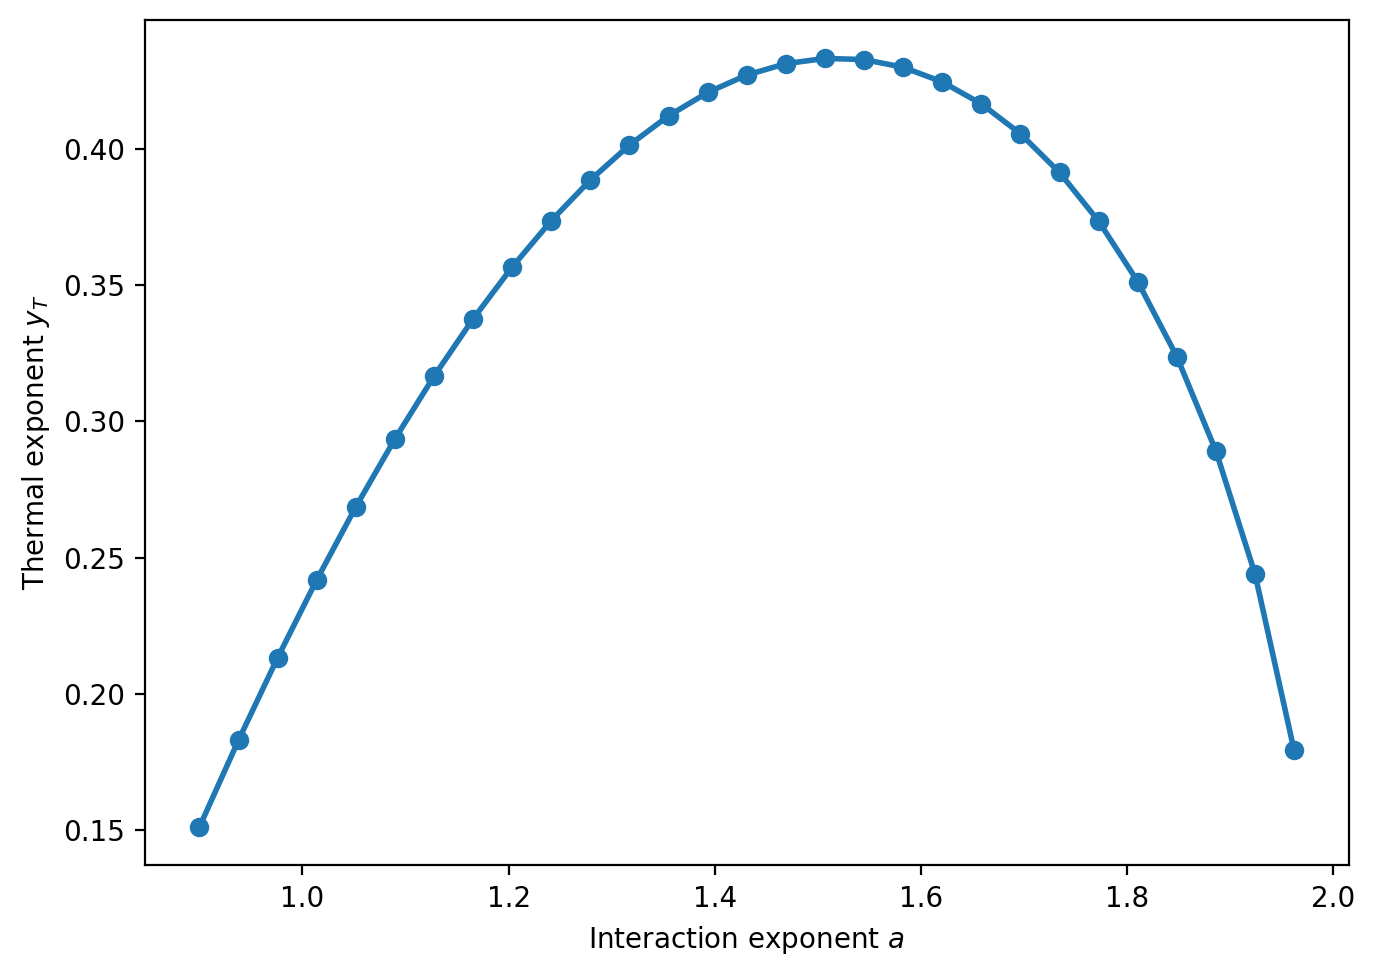

In [21]:
a_values = np.linspace(0.9, 2.0, 30)   # interaction exponents
D = 1000                                # full cutoff
n = 200                                 # number of head couplings
b = 3.0                                # RG rescaling factor
eps0 = 1e-7                            # finite-difference step
newton_tol = 1e-10

# Storage
yT_values = []
Jc_values = []

# Consistency check
r_max = (D - 2) // 3
if n > r_max:
    raise ValueError(f"Choose n <= r_max = {r_max}")

# ---------------------------
# Main loop over a
# ---------------------------
for a in a_values:
    print(f"\n=== Processing a = {a:.3f} ===")

    # 1) Find critical coupling Jc(a)
    Jc = find_Jc(a)
    print(f"Jc(a={a:.3f}) = {Jc:.6g}")
    Jc_values.append(Jc)

    # 2) Initial guess for Newton (power-law head)
    x0 = np.zeros(n + 1)
    for r in range(1, n + 1):
        x0[r] = Jc / (r ** a)

    # 3) Newton–Raphson fixed point
    x_star, J_star_full, info = newton_fixed_point_rg(
        a=a, D=D, n=n, x0_head=x0, tol_F=newton_tol, verbose=False)

    if not info["converged"]:
        print("⚠ Newton did not fully converge; skipping this a.")
        yT_values.append(np.nan)
        continue

    # 4–6) Compute thermal exponent yT
    yT, lambda_T, eigvals, Tmat = thermal_exponent_yT(
        x_head_star=x_star, a=a, D=D, n=n, b=b, eps0=eps0, verbose=False)

    print(f"yT(a={a:.3f}) = {yT:.6f}")
    yT_values.append(yT)

# Convert to arrays
a_values = np.array(a_values)
yT_values = np.array(yT_values)

# ---------------------------
# Plot yT vs a
# ---------------------------
plt.figure(figsize=(7, 5))
plt.plot(a_values, yT_values, "o-", lw=2)
plt.xlabel("Interaction exponent $a$")
plt.ylabel("Thermal exponent $y_T$")
plt.tight_layout()
plt.show()

In [23]:
from numba import njit

@njit(cache=True)
def dH_dH(J, eps=1e-6):
    """
    Derivative dH'/dH at H=0, via finite difference.
    """
    H0    = renormalized_field(J, 0.0)
    H_eps = renormalized_field(J, eps)

    if not np.isfinite(H0) or not np.isfinite(H_eps):
        return np.nan

    return (H_eps - H0) / eps


def magnetic_exponent_yH(J_star, eps=1e-8, b=3.0):
    alpha = dH_dH(J_star, eps=eps)

    if not np.isfinite(alpha) or alpha <= 0:
        raise RuntimeError(f"dH'/dH invalid or non-positive at fixed point: {alpha}")

    y_H = np.log(alpha) / np.log(b)
    return y_H, alpha


=== Processing a = 0.900 ===
Jc(a=0.900) = 0.0811161
alpha=dH'/dH=1.7002972,  yH=0.483158

=== Processing a = 0.938 ===
Jc(a=0.938) = 0.101737
alpha=dH'/dH=1.7506687,  yH=0.509732

=== Processing a = 0.976 ===
Jc(a=0.976) = 0.122198
alpha=dH'/dH=1.8020185,  yH=0.536047

=== Processing a = 1.014 ===
Jc(a=1.014) = 0.14258
alpha=dH'/dH=1.8541735,  yH=0.562017

=== Processing a = 1.052 ===
Jc(a=1.052) = 0.162945
alpha=dH'/dH=1.9069552,  yH=0.587567

=== Processing a = 1.090 ===
Jc(a=1.090) = 0.18337
alpha=dH'/dH=1.960183,  yH=0.612625

=== Processing a = 1.128 ===
Jc(a=1.128) = 0.203913
alpha=dH'/dH=2.013677,  yH=0.637133

=== Processing a = 1.166 ===
Jc(a=1.166) = 0.224648
alpha=dH'/dH=2.0672594,  yH=0.661037

=== Processing a = 1.203 ===
Jc(a=1.203) = 0.245632
alpha=dH'/dH=2.1207571,  yH=0.684293

=== Processing a = 1.241 ===
Jc(a=1.241) = 0.266933
alpha=dH'/dH=2.1740025,  yH=0.706864

=== Processing a = 1.279 ===
Jc(a=1.279) = 0.288609
alpha=dH'/dH=2.2268349,  yH=0.728720

=== Processi

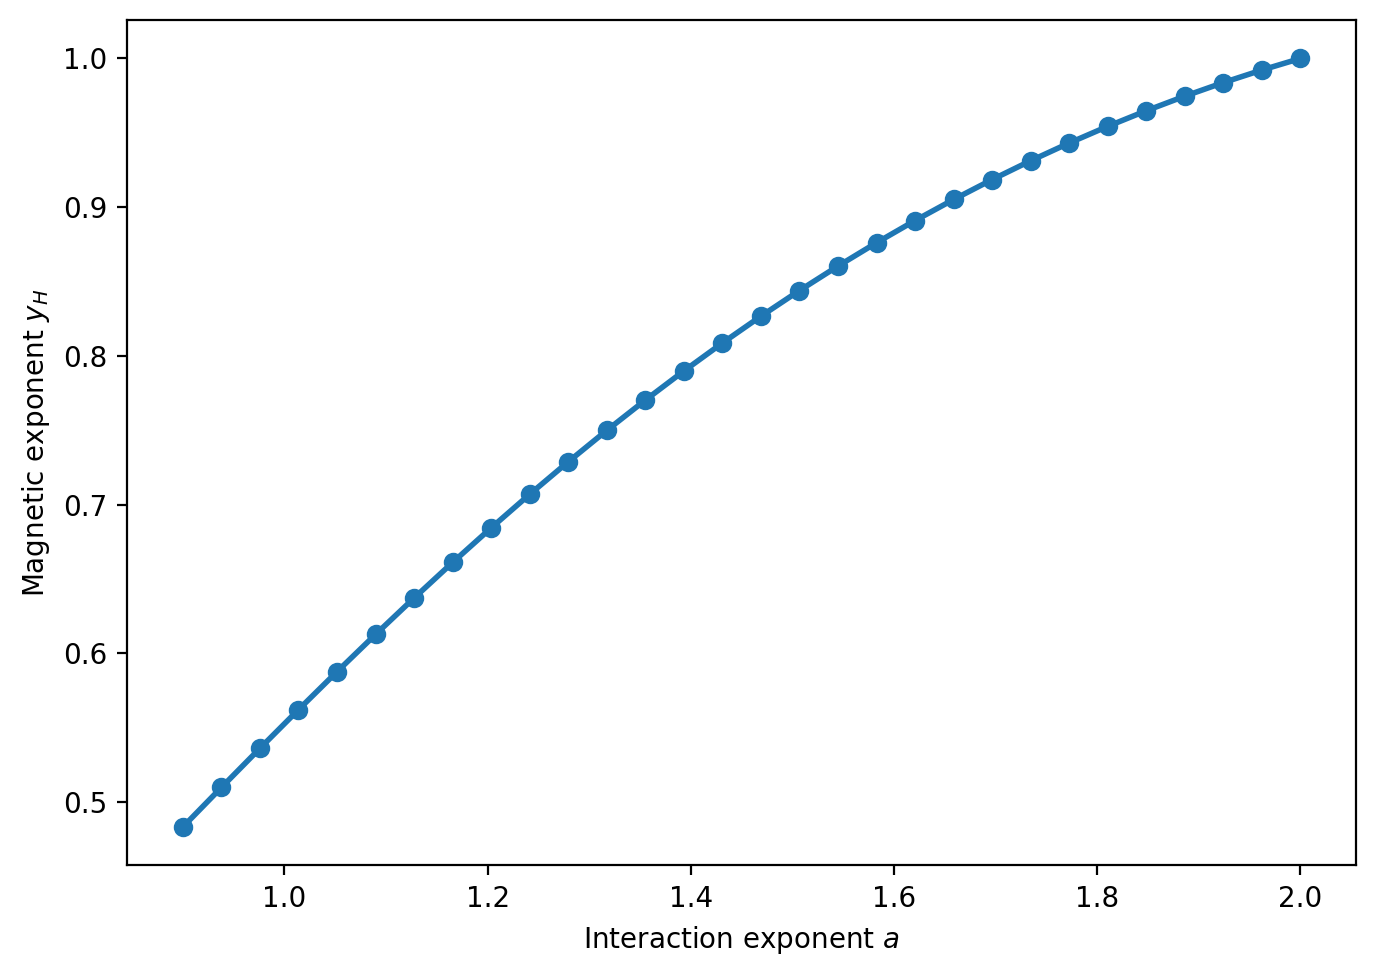

In [24]:
a_values = np.linspace(0.9, 2.0, 30)   # interaction exponents
D = 200                                # fixed cutoff for full J
n = 50                                 # head dimension (must satisfy n <= (D-2)//3)
b = 3.0                                # RG scale factor
newton_tol = 1e-10

# Finite-difference step for field derivative
H_eps = 1e-8

# Storage
yH_values = []
alpha_values = []   # alpha = dH'/dH
Jc_values = []

# Consistency check for exact-head region
r_max = (D - 2) // 3
if n > r_max:
    raise ValueError(f"Choose n <= r_max = {r_max}, but n={n}")

# ---------------------------
# Main loop over a
# ---------------------------
for a in a_values:
    print(f"\n=== Processing a = {a:.3f} ===")

    # 1) Find critical coupling Jc(a)
    Jc = find_Jc(a)
    print(f"Jc(a={a:.3f}) = {Jc:.6g}")
    Jc_values.append(Jc)

    # 2) Initial head guess from power law at Jc
    x0 = np.zeros(n + 1, dtype=np.float64)
    for r in range(1, n + 1):
        x0[r] = Jc / (r ** a)

    # 3) Newton fixed point for head, with fixed-size tail closure
    x_star_head, J_star_full, info = newton_fixed_point_rg(
        a=a, D=D, n=n, x0_head=x0, tol_F=newton_tol, verbose=False)

    if not info.get("converged", False):
        print("⚠ Newton did not converge; skipping this a.")
        yH_values.append(np.nan)
        alpha_values.append(np.nan)
        continue

    # 4) Magnetic exponent yH at fixed point (use full J vector)
    try:
        yH, alpha = magnetic_exponent_yH(J_star_full, eps=H_eps, b=b)
    except RuntimeError as e:
        print(f"⚠ yH failed at a={a:.3f}: {e}")
        yH, alpha = np.nan, np.nan

    print(f"alpha=dH'/dH={alpha:.8g},  yH={yH:.6f}")
    yH_values.append(yH)
    alpha_values.append(alpha)

# Convert to arrays
a_values = np.array(a_values)
yH_values = np.array(yH_values)
alpha_values = np.array(alpha_values)

# ---------------------------
# Plot yH vs a
# ---------------------------
plt.figure(figsize=(7, 5))
plt.plot(a_values, yH_values, "o-", lw=2)
plt.xlabel("Interaction exponent $a$")
plt.ylabel("Magnetic exponent $y_H$")
plt.tight_layout()
plt.show()